In [34]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from matplotlib.image import imread
import cv2


In [35]:
def image_retrive(path):
    folder = {f:i for i,f in enumerate(os.listdir(f'{path}'))}
    labels=[]
    M=[]
    #90 x 134
    for p_class in folder.keys():
      
        images=[f for f in os.listdir(f'{path}/{p_class}')]
        for n in range(0,len(images)):
            image=cv2.imread(f'{path}/{p_class}/{images[n]}')
            
            if image.shape[0] == 90 and image.shape[1]==134:
               
                M.append(image)
                labels.append(p_class)
            else:
                z_matrix=np.zeros((90,134,3))
                if image.shape[0]>z_matrix.shape[0] or image.shape[1] > z_matrix.shape[1]:
                    offset=abs(image.shape[0]-z_matrix.shape[0])
                    offset2=abs(image.shape[1]-z_matrix.shape[1])
                    z_matrix[:,:]=image[offset:,offset2:,:]
                M.append(z_matrix)
                labels.append(p_class)             
    return M, labels


In [36]:
M, labels=image_retrive('Train/Train')
T,labels2 = image_retrive('Test/Test')
V, labels3 = image_retrive('Validation/Validation')
M=np.array(M)
T=np.array(T)
V=np.array(V)
def ravel_rgb(M):
    R,G,B=np.zeros(90*134), np.zeros(90*134), np.zeros(90*134)
    #R=np.expand_dims(R,axis=0)
    for b in range(M.shape[0]):
        
        
        r= M[b,:,:,0].ravel()
        g= M[b,:,:,1].ravel()
        b= M[b,:,:,2].ravel()

        R=np.column_stack((R,r))
        G=np.column_stack((G,g))
        B=np.column_stack((B,b))
    R=R[:,1:]
    G=G[:,1:]
    B=B[:,1:]
    return R,G,B

R,G,B=ravel_rgb(M)
R_t,G_t,B_t=ravel_rgb(T)




(12060, 1322)
0.32666666666666666
(12060, 1322)
0.31333333333333335
(12060, 1322)
0.31333333333333335


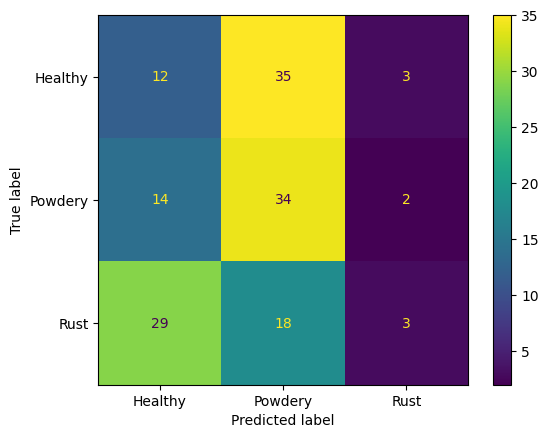

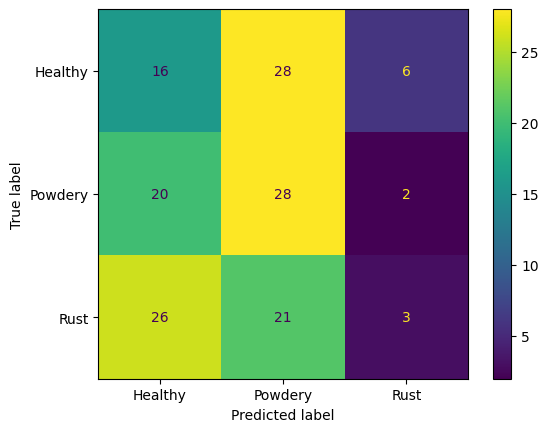

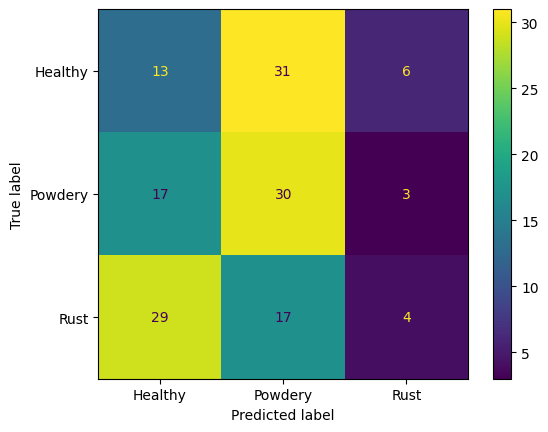

In [37]:


def confusion_matrices_sln(channel, channel_test, labels, labels2):
    df=pd.DataFrame(channel, columns=[i for i in range(channel.shape[1])])
    df_test=pd.DataFrame(channel_test, columns=[i for i in range(channel_test.shape[1])])
    print(df.shape)
    n_train, y_train=np.unique(labels, return_inverse=True)
    _, y_test=np.unique(labels2, return_inverse=True)
        
    single_layer_coefficients=np.array([y_train @ np.linalg.pinv(df)])


    prevision_single_layer=df_test.T @ single_layer_coefficients.T


    reshaped_prev=prevision_single_layer.round(0).astype(int).to_numpy().ravel() 
    reshaped_prev=np.abs(reshaped_prev)
    reshaped_prev[np.where(reshaped_prev > 2)]=2

    cm=sk.metrics.confusion_matrix(y_test, reshaped_prev)
    print(sk.metrics.accuracy_score(y_test, reshaped_prev))
    disp=sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm[-3:,-3:], display_labels=n_train)
    disp.plot()
    
    return df,df_test

df_r, df_rt=confusion_matrices_sln(R,R_t, labels,labels2)
df_g, df_gt=confusion_matrices_sln(G,G_t, labels,labels2)
df_b, df_bt=confusion_matrices_sln(B,B_t, labels,labels2)

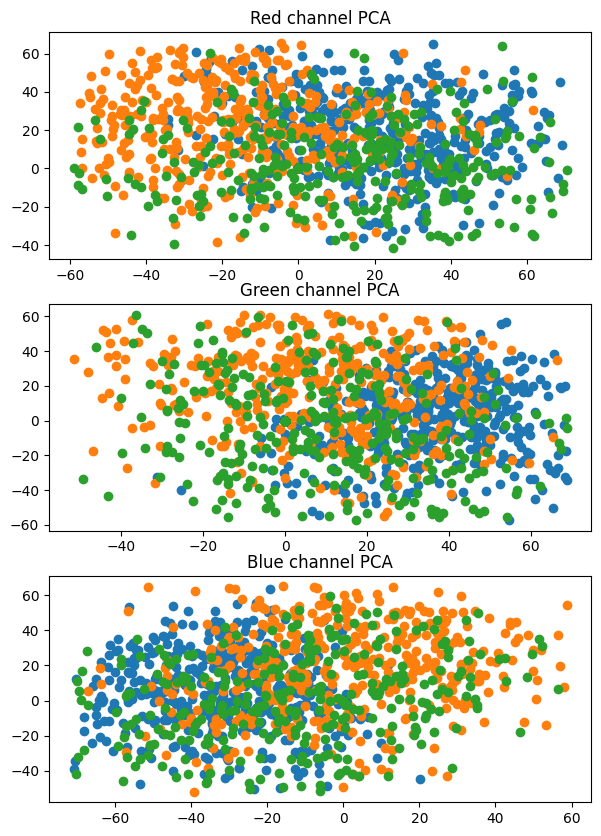

In [38]:
def transf(df,numerical_labels):
    scaler=sk.preprocessing.StandardScaler().fit(df)
    df=pd.DataFrame(scaler.transform(df))
    
    df=df.T
    
    U,S,Vt=sk.decomposition.randomized_svd(df, n_components=2)
   

    D=(1/df.shape[0]) * np.square(np.diag(S))
    V=Vt.T
    pc=V[:,:2]

    PCA_Dataset=df @ pc

    mask=(PCA_Dataset[0]<PCA_Dataset[0].quantile(0.99)) & (PCA_Dataset[0]>PCA_Dataset[0].quantile(0.01)) & (PCA_Dataset[1]<PCA_Dataset[1].quantile(0.99)) & (PCA_Dataset[1]>PCA_Dataset[1].quantile(0.01)) 
    
    PCA_Dataset=pd.DataFrame(PCA_Dataset[mask])
    labels=pd.Series(numerical_labels)
    PCA_Dataset['labels']=labels
    
    return PCA_Dataset,mask, pc, scaler


n_train, y_train=np.unique(labels, return_inverse=True)
_, y_test=np.unique(labels2, return_inverse=True)
_, y_validation=np.unique(labels3, return_inverse=True)

fig,(ax1, ax2, ax3)=plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(7)
PCA_Dataset_r,m0,pc0,r0=transf(df_r, y_train)

ax1.set_title('Red channel PCA')
for c in range(3):
    ax1.scatter(PCA_Dataset_r.iloc[:,0][PCA_Dataset_r['labels']==c], PCA_Dataset_r.iloc[:,1][PCA_Dataset_r['labels']==c])

ax2.set_title('Green channel PCA')
PCA_Dataset_g,m1,pc1,r1=transf(df_g, y_train)
for c in range(3):
    ax2.scatter(PCA_Dataset_g.iloc[:,0][PCA_Dataset_g['labels']==c], PCA_Dataset_g.iloc[:,1][PCA_Dataset_g['labels']==c])

ax3.set_title('Blue channel PCA')

PCA_Dataset_b,m2,pc2,r2=transf(df_b, y_train)
for c in range(3):
    ax3.scatter(PCA_Dataset_b.iloc[:,0][PCA_Dataset_b['labels']==c], PCA_Dataset_b.iloc[:,1][PCA_Dataset_b['labels']==c])



0.42


/home/fabrizio-verace/Scrivania/ML_projects/my_env/lib/python3.12/site-packages/sklearn/inspection/_plot/decision_boundary.py:226: UserWarning: 'colors' is ignored in favor of 'multiclass_colors' in the multiclass case when the response method is 'decision_function' or 'predict_proba'.
  warnings.warn(


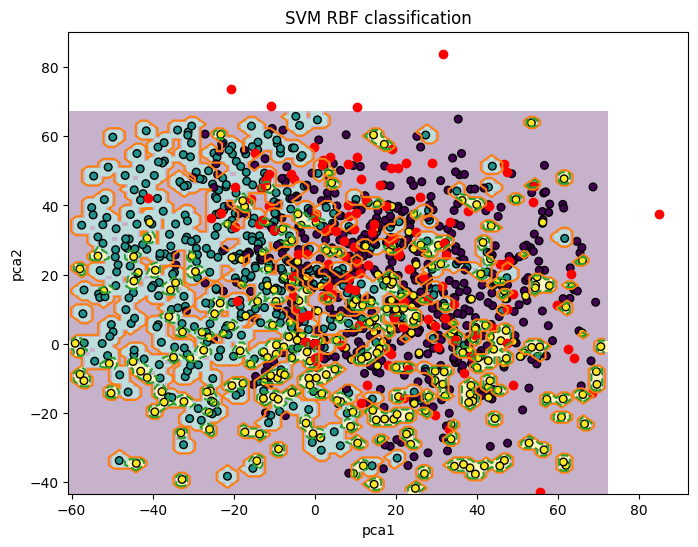

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

svc=sk.svm.SVC(kernel='rbf',gamma='auto', C=1).fit(PCA_Dataset_r.iloc[:,:2].to_numpy(), PCA_Dataset_r['labels'].to_numpy())
_, ax = plt.subplots(figsize=(8, 6))
common_params = {"estimator": svc, "X": PCA_Dataset_r.iloc[:,:2], "ax": ax}
DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )

DecisionBoundaryDisplay.from_estimator(
        **common_params,    
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

ax.scatter(PCA_Dataset_r.iloc[:,0], PCA_Dataset_r.iloc[:,1],c=PCA_Dataset_r['labels'], s=30, edgecolors="k")


scaler=sk.preprocessing.StandardScaler().fit(df_rt)
df_rt=pd.DataFrame(scaler.transform(df_rt))
    
df_rt=df_rt.T




PCA_Dataset_test=df_rt @ pc0
PCA_Dataset_test['labels']=y_test

ax.scatter(PCA_Dataset_test[0], PCA_Dataset_test[1], color='red')
pred=svc.predict(PCA_Dataset_test.iloc[:,:2].to_numpy())

print(sk.metrics.accuracy_score(y_test, pred))
plt.title('SVM RBF classification')
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.show()

In [40]:
size=256

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(size, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(size, activation='relu'),

  tf.keras.layers.Dense(3, activation='softmax')
])

df_reshaped = M/255


prediction = model(df_reshaped).numpy()
tf.nn.softmax(prediction).numpy()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train, prediction).numpy()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


model.fit(df_reshaped, y_train, epochs=30,validation_data=(V/255, y_validation))




Epoch 1/30


/home/fabrizio-verace/Scrivania/ML_projects/my_env/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3799 - loss: 7.0538 - val_accuracy: 0.3333 - val_loss: 1.6872
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5613 - loss: 1.1366 - val_accuracy: 0.3667 - val_loss: 1.2160
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6369 - loss: 0.8442 - val_accuracy: 0.3667 - val_loss: 1.3184
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6625 - loss: 0.8260 - val_accuracy: 0.3667 - val_loss: 1.2895
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.6741 - loss: 0.7353 - val_accuracy: 0.3500 - val_loss: 1.3477
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6612 - loss: 0.7862 - val_accuracy: 0.4500 - val_loss: 1.3082
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6189 - loss: 0.7730 - val_accuracy: 0.3000 - val_loss: 1.5145
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6581 - loss: 0.7044 - val_accuracy: 0.3500 - val_loss: 1.

5/5 - 0s - 7ms/step - accuracy: 0.6467 - loss: 0.8269
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7d85c8f61940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


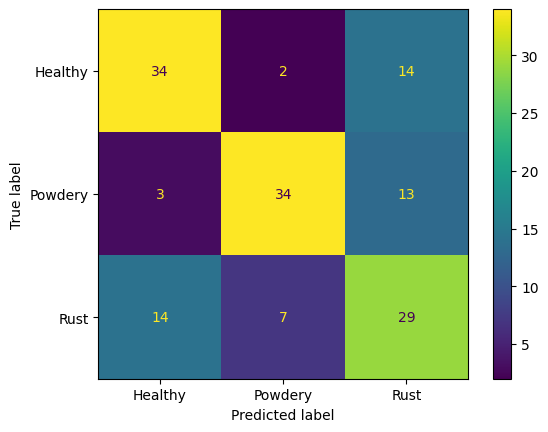

In [41]:

model.evaluate(T/255, y_test, verbose=2)
pred=model.predict(T/255)

prediction_l=[]
for row in pred:
    prediction_l.append(list(row).index(max(row)))

cm=sk.metrics.confusion_matrix(y_test, prediction_l)
disp=sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm[-3:,-3:], display_labels=n_train)
disp.plot()


max acc: 0.4866666666666667 with k: 5


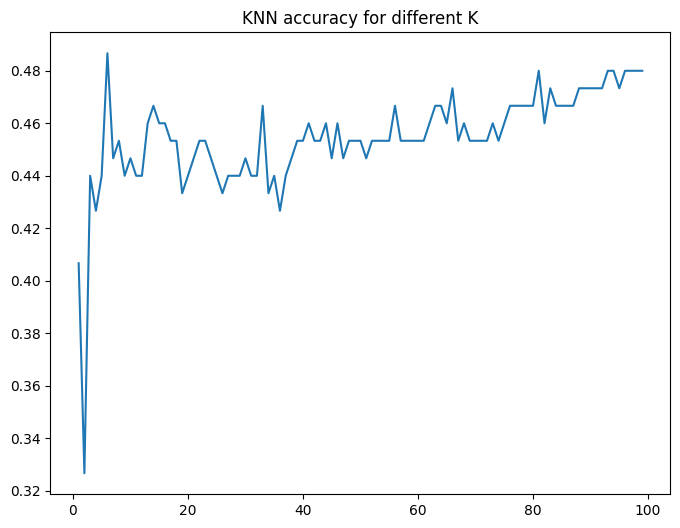

In [42]:
fig,ax= plt.subplots(figsize=(8,6))
accuracy=[]
for x in range(1,100):
    knn=sk.neighbors.KNeighborsClassifier(n_neighbors=x).fit(PCA_Dataset_r.iloc[:,:2], PCA_Dataset_r['labels'])

    prediction=knn.predict(PCA_Dataset_test.iloc[:,:2])
    accuracy.append(sk.metrics.accuracy_score(PCA_Dataset_test['labels'], prediction))

print(f'max acc: {np.max(accuracy)} with k: {accuracy.index(np.max(accuracy)) }')
ax.set_title('KNN accuracy for different K')

ax.plot(np.arange(1,len(accuracy)+1),accuracy)